In [10]:
%load_ext autoreload
%autoreload 2
from mapvbvd import mapVBVD
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and prepare the data (Siemens example)

In [12]:
supressed_file = Path('original_data/meas_MID310_STEAM_metab_FID115673.dat')
suppressed_raw = mapVBVD(supressed_file,quiet=True)
suppressed_raw.image.removeOS=False #Twix files are oversampled by a factor of two 'for free' which can opitonally be removed
supp_block = suppressed_raw.image.unsorted()

newshape = (1,1,1)+supp_block.shape
supp_block = supp_block.reshape(newshape)

dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9 # For nifti pixel dim
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
spectral_width_hz = 1/(suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9)

### Check frequency convention of data

From the [numpy fft documentation](https://numpy.org/doc/stable/reference/routines.fft.html#implementation-details) the dft is defined as  
![image.png](https://numpy.org/doc/stable/_images/math/192fb50712b8530c868a329a12a27077c012daa9.svg)  
This matches Eqn [81] of Levitt (The Signs of Frequencies and Phases in NMR. Journal of Magnetic Resonance 1997;126:164–182 doi: [10.1006/jmre.1997.1161](https://doi.org/10.1006/jmre.1997.1161)). An FFT shift is required as the sum is defined from 0 to n-1. This definition also matches that used in [MATLAB](https://uk.mathworks.com/help/matlab/ref/fft.html).

Following the conventions of Levitt the frequency scale should increase from left to right. For nuclei with a gyromagnetic ratio > 0 this corresponds to resonances from nuclei with less shielding (more deshielding) and therefore experiencing a higher magnetic field, appearing on the left. I.e. they have more negative (higher magnitude) Larmor frequencies  $$\omega=-\gamma B_0.$$

In the literature this is often also plotted with a different frequency scale showing more positive relative frequencies on the left. This preserves the orientation of the spectrum but corresponds to a scale equal to  $|\omega|-|\omega_{\textrm{ref}}|$.

It is worth stating that the reasons behind this convention are subtle, complex, and mostly movitvated by a desire for consistent signs in the relevant Hamiltonian. The interested reader is referred to Levitt's paper, which is both easy to read and compelling.

Here, we plot the spectrum on:  
1. An absolute frequency scale. I.e. the Larmor frequency is approximately -300 MHz.
2. A typical display magnitude relative frequency scale corresponding to $|\omega|-|\omega_{\textrm{ref}}|$. *Requires a deliberate axes inversion.*
3. A chemical shift scale referenced to TMS. *Requires a deliberate axes inversion.*

This data is a 7T SVS 1H-MRS acquisition and was collected with the spectrometer reference frequency aligned to water. Oversampling has not been removed so limited receiver bandwidth is apparent in these plots.

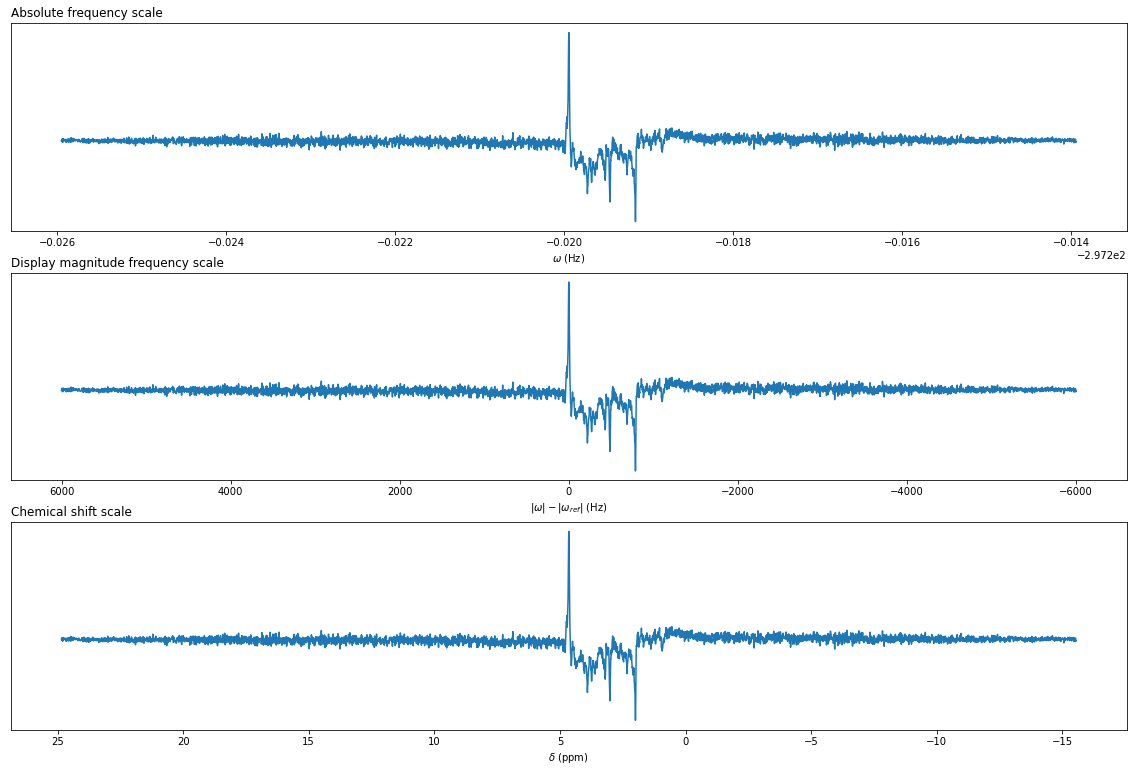

In [17]:
# Do a quick and dirty pre-processing job here to get some high SNR data, take one coil.
supp_block_avg = np.mean(supp_block,axis=5)[:,:,:,:,0]
test_FID = np.squeeze(supp_block_avg[0,0,0,:])

# Siemens twix data appears to need a conjugate to achieve the right convention
test_FID = test_FID.conj()

# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
npoints = supp_block_avg.shape[3]
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = 4.65+ frequency_axis/transmitter_frequency_mhz

spec_fft = np.fft.fftshift(np.fft.fft(test_FID))
#Display

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

### Check "handedness" of data

The DICOM standard in section [C.8.14.4.1](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.14.4.html) tries to make a definition of in what sense the magnetization should be viewed and therefore the frequency axis direction.

    #### C.8.14.4.1 Spectroscopy Data

    The spectral data points are ordered in sequence of increasing time in the case that the Signal Domain Columns (0028,9003) or Signal Domain Rows (0028,9235) Attributes contain the value TIME.  

    The apparent rotation of magnetization in a quadrature representation shall be counterclockwise (from the (positive) real part to the (positive) imaginary part) for positive relative frequencies.  

    ##### Note
        When Complex time data points are transformed by a straightforward Fourier transformation to complex spectral data points, these are ordered from low frequency to high frequency.
        
However this definition doesn't define well what is meant by a quadrature representation (beyond detecting real and imaginary parts) nor (and more importantly) does it define what is meant by "positive relative frequencies". We assume that if the FID is viewed from above, its handedness should reveal itself:

Define a right-handed coordinate frame (right pannel):  
![image.png](https://upload.wikimedia.org/wikipedia/commons/e/e2/Cartesian_coordinate_system_handedness.svg)

Define the x-axis to be the real component, y the imaginary component and z as time.  
Display as the figure above and looking down the time axis.

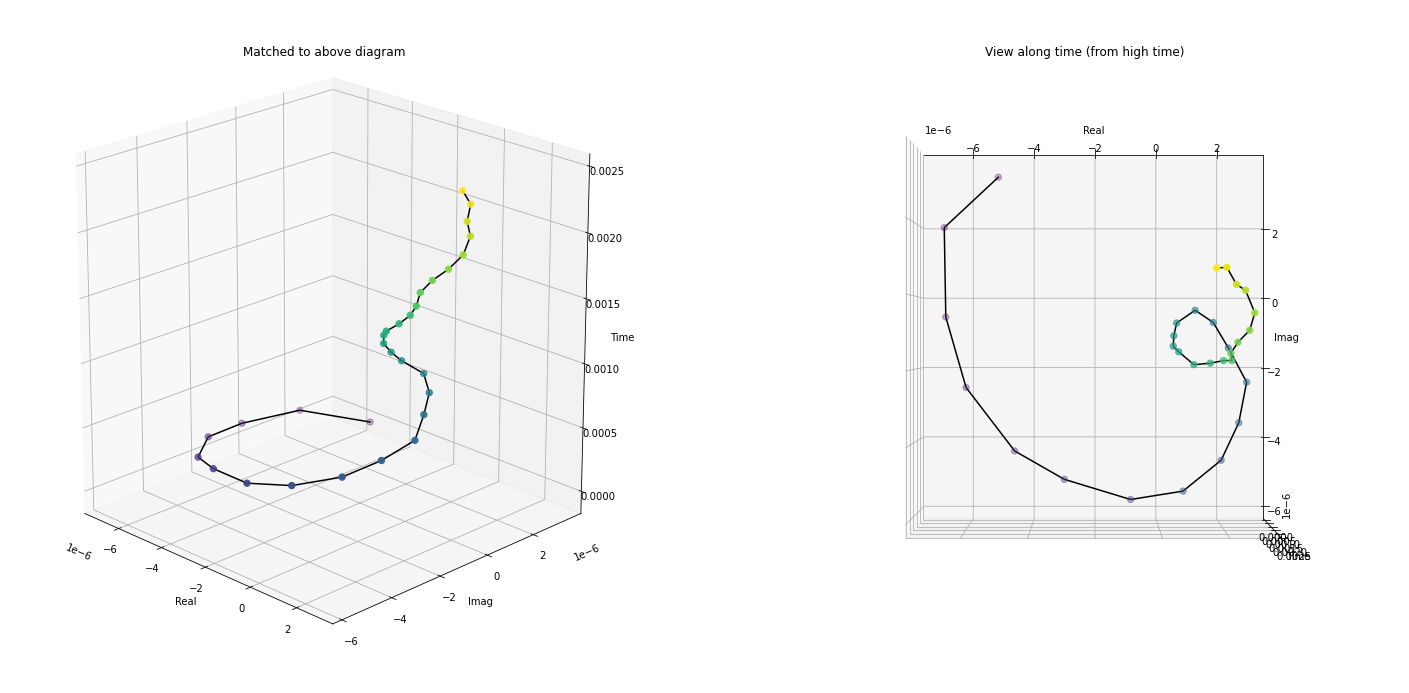

In [14]:
time_axis = dwelltime*np.arange(0,test_FID.size)
fig = plt.figure(figsize=(25,12.5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(20, -45)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Matched to above diagram')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(90, -90)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('View along time (from high time)')
plt.show()

From these plots we can see that for nuclei with a positive gyromagnetic ratio $(\gamma>0)$ positive frequencies (on the absolute scale, equivalent to lower chemical shifts) are counter-clockwise (positive).
![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Right-hand_grip_rule.svg/220px-Right-hand_grip_rule.svg.png)

I think that for nuclei with a negative gyromagnetic ratio $(\gamma<0)$ then this same relationship should hold if the time domain data is conjugated before storage.


### Suggested specification wording
- The time-domain spectral data points are ordered in sequence of increasing time and contain the value TIME.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time):  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.